### Homework 2: Uncertainty and Vision
CS-229 Spring 2023

The goal of this assignment is to get familiar with training a computer vision task (Segmentation) with PyTorch, and to measure confidence calibration in your system. 

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets 
from torchvision.models.segmentation import fcn_resnet50

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

torch.manual_seed(123) 

In [2]:
class ToIntTensor(transforms.ToTensor):
    """A custom transform that replaces "ToTensor". ToTensor always converts to a 
    a float in range [0,1]. This one converts to an integer, which can represent
    our class labels per pixel in an image segmentation problem"""
    def __call__(self, pic):
        tensor = super().__call__(pic)
        tensor = (tensor * 255).to(torch.int64)
        return tensor

def get_voc_dataloader(batch_size=16):
    """Get the VOC 2007 segmentation dataset and return PyTorch 
    dataloaders for both training and validation. 
    """
    # TODO: 2 points. Define image transforms for both the input image AND the "label" image.
    # Remember, the labels are one category (integer) per pixel. So, while the image_transform
    # normalize the values to have mean zero and unit standard deviation, you shouldn't 
    # do that with the labels, which have to be integers. I provided a "ToIntTensor" transform
    # above to use for the label transform, instead of ToTensor which always turns images to floats. 
    # Also, we want to resize/crop images to be all the same size, a power of 2, and 
    # we should transform the label and image in the same way when changing size.
    # The size of images will drastically impact memory usage - I suggest targeting 128 x 128 
    # or even 64 x 64 if memory constraints are an issue. 
    image_transforms = transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]) # TODO
    label_transforms = transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        ToIntTensor()
    ]) # TODO

    # This downloads the data automatically and creates a "dataset" object that applies the transforms
    data_dir = "Data/"  # TODO: Specify path to save data
    train_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='train', download=True, transform=image_transforms, target_transform=label_transforms)
    val_dataset = datasets.VOCSegmentation(data_dir, year='2007', image_set='val', download=True, transform=image_transforms, target_transform=label_transforms)

    # Create data loaders for the datasets - necessary for efficient training
    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_dl, val_dl
    
    

In [3]:
train_dl, val_dl  = get_voc_dataloader() 

Using downloaded and verified file: Data/VOCtrainval_06-Nov-2007.tar
Extracting Data/VOCtrainval_06-Nov-2007.tar to Data/
Using downloaded and verified file: Data/VOCtrainval_06-Nov-2007.tar
Extracting Data/VOCtrainval_06-Nov-2007.tar to Data/


In [4]:
def train_epoch(model, train_dl, val_dl, optimizer, device):
    """
    Train one epoch of model with optimizer, using data from train_dl.
    Do training on "device". 
    Return the train and validation loss and validation accuracy.
    """
    # We'll use the cross entropy loss. There's a nice feature that it
    # allows you to "ignore_index". In this case index 255 is the mask to ignore
    criterion = nn.CrossEntropyLoss(ignore_index=255)  # recommend to use in constructing loss

    # TODO: Train (3 points)
    # Iterate over the train dataloader
    # Put data batch on same device as model
    # "Forward pass" - run data through model, and use output to calculate loss. 
    # "backward pass"
    # Remember to keep track of training loss during loop. 
    model.train() 
    train_loss = 0.0
    for inputs, targets in train_dl:
        inputs = inputs.to(device)
        targets = targets.squeeze(dim=1).to(device)  

        optimizer.zero_grad()
        
        outputs = model(inputs)
        outputs = outputs['out'] 
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        
    train_loss /= len(train_dl.dataset)
    
        
    # TODO: Validation loss and accuracy (2 points)
    # estimate the loss on the validation dataset
    # The network should be in "eval" mode (remember to go back to train mode for training)
    # Turn off grad tracking for speed 
    # Accuracy on validation datais very helpful to output - 
    # 69 percent of pixels are "background" - we hope to get better accuracy than that!
    
    val_loss = 0.0
    correct = 0
    total = 0

    model.eval()
    
    with torch.no_grad():
        for inputs, targets in val_dl:
            inputs = inputs.to(device)
            targets = targets.squeeze(dim=1).to(device)

            outputs = model(inputs)
            outputs = outputs['out'] 
            loss = criterion(outputs, targets)

            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            mask = targets != 255  # ignore masks 
            total += mask.sum().item() 
            correct += (predicted == targets)[mask].sum().item()

    val_loss /= len(val_dl.dataset)
    accuracy = correct / total

    model.train()

    return train_loss, val_loss, accuracy 

        

### Main loop

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

# Define some hyperparameters
batch_size = 64             # Adjust batch size to make maximal use of GPU without running out of memory 
epochs = 50 
learning_rate = 0.01
n_class = 21                # The class labels are 0...20. The label "255" is interpreted as a "mask" meant to be ignored

# Load model and data
model_resnet50 = fcn_resnet50(n_class=n_class).to(device) 

train_dl, val_dl = get_voc_dataloader(batch_size=batch_size)
# Training loop
optimizer = optim.SGD(model_resnet50.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.)
train_losses_resnet50, val_losses_resnet50, accuracy_resnet50 = [], [], [] 
for epoch in range(epochs):
    train_loss, val_loss, accuracy = train_epoch(model_resnet50, train_dl, val_dl, optimizer, device)
    accuracy_resnet50.append(accuracy) 
    train_losses_resnet50.append(train_loss) 
    val_losses_resnet50.append(val_loss)
    print('Epoch %d: Train loss: %.3f | Val loss: %.3f | Acc: %.3f' % (epoch+1, train_loss, val_loss, accuracy)) 

Using downloaded and verified file: Data/VOCtrainval_06-Nov-2007.tar
Extracting Data/VOCtrainval_06-Nov-2007.tar to Data/
Using downloaded and verified file: Data/VOCtrainval_06-Nov-2007.tar
Extracting Data/VOCtrainval_06-Nov-2007.tar to Data/
Epoch 1: Train loss: 2.647 | Val loss: 2.467 | Acc: 0.475
Epoch 2: Train loss: 0.998 | Val loss: 1.162 | Acc: 0.742
Epoch 3: Train loss: 0.882 | Val loss: 1.301 | Acc: 0.683
Epoch 4: Train loss: 0.685 | Val loss: 0.990 | Acc: 0.752
Epoch 5: Train loss: 0.546 | Val loss: 0.798 | Acc: 0.782
Epoch 6: Train loss: 0.450 | Val loss: 0.964 | Acc: 0.761
Epoch 7: Train loss: 0.404 | Val loss: 0.843 | Acc: 0.786
Epoch 8: Train loss: 0.350 | Val loss: 0.851 | Acc: 0.787
Epoch 9: Train loss: 0.310 | Val loss: 0.829 | Acc: 0.789
Epoch 10: Train loss: 0.289 | Val loss: 0.867 | Acc: 0.785
Epoch 11: Train loss: 0.270 | Val loss: 0.794 | Acc: 0.794
Epoch 12: Train loss: 0.253 | Val loss: 0.725 | Acc: 0.803
Epoch 13: Train loss: 0.245 | Val loss: 0.730 | Acc: 0.80

## Post training visualization and analysis

In [7]:
# TODO: Train and test loss plot
# TODO: Print out an example image, true segmentation, and predicted segmentation
# 1 point
# Use a colormap to get good visualizations of the segmentation classes
# cmap = plt.cm.get_cmap('tab20', n_class + 1)  # tab20 is a colormap with 20 distinct colors
# cmap(numpy class array) outputs something with nice colors

In [6]:
def plot_loss(train_loss, val_loss):
    plt.plot(train_loss, label='train loss')
    plt.plot(val_loss, label='val loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show() 


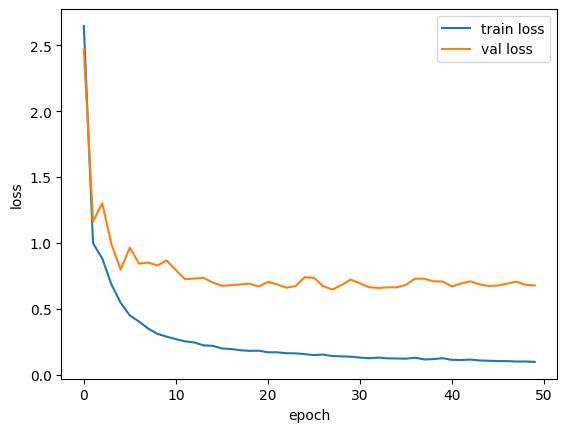

In [7]:
plot_loss(train_losses_resnet50, val_losses_resnet50)

In [8]:
def segmentation_plot(model, val_dl, idx=None):
    model.eval()
    with torch.no_grad():
        if idx is None:
            idx = np.random.randint(len(val_dl.dataset))
        img, target = val_dl.dataset[idx]
        print(idx)
        img = img.unsqueeze(0)
        output = model(img.to(device))['out'] 
        pred = output.argmax(dim=1).squeeze(0).cpu().numpy()
        

        classes = val_dl.dataset.targets 
        cmap = plt.cm.get_cmap('tab20', len(classes))
        
        # plot the images and segmentations
        fig, axs = plt.subplots(1, 3, figsize=(10, 5))
        axs[0].imshow(img.squeeze(0).permute(1, 2, 0))
        axs[0].set_title('Image')
        axs[1].imshow(target.squeeze(0), cmap=cmap, vmin=0, vmax=len(classes)-1)
        axs[1].set_title('Ground Truth')
        axs[2].imshow(pred, cmap=cmap, vmin=0, vmax=len(classes)-1)
        axs[2].set_title('Predicted')
        plt.show()

/tmp/ipykernel_2543375/1596363464.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(classes))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47


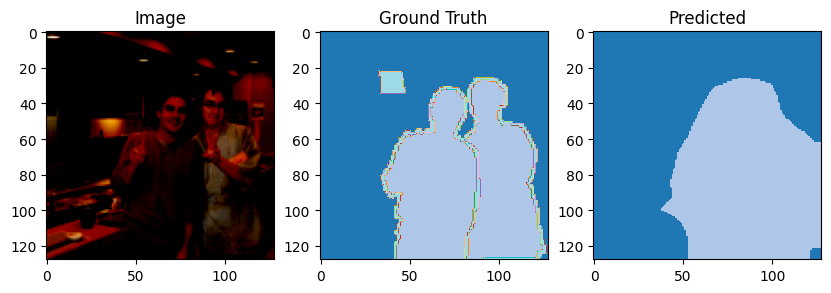

In [9]:
segmentation_plot(model_resnet50, val_dl, 47) 

In [22]:

def calc_ECE(model):
    model.eval()
    with torch.no_grad():
        all_acc = []
        all_conf = []
        for i, (inputs, labels) in enumerate(val_dl):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)['out']
            labels = labels.squeeze(1).flatten(start_dim=1)  # batch, h, w  - integer values 0..20 or 255 for mask
            predicted_label = outputs.argmax(axis=1).flatten(start_dim=1)  # batch, h, w, integer 0...20  
            probs = outputs.softmax(axis=1)  # batch, n_class, h, w
            confidence = probs.max(axis=1).values.flatten(start_dim=1)  # Confidence in predicted label
            accuracy = (predicted_label == labels)
            accuracy_filter = accuracy[labels < 255]
            confidence_filter = confidence[labels < 255]
            all_acc.append(accuracy_filter)
            all_conf.append(confidence_filter)
            
    all_acc = torch.cat(all_acc).cpu().numpy()  # accuracy to predict pixel class across all pixels and images, excluding masks
    all_conf = torch.cat(all_conf).cpu().numpy()  # confidence of prediction for each pixel and image, excluding masks
            
    # Get the average confidence and accuracy for points within different confidence ranges
    bins = 10
    bin_boundaries = np.linspace(0, 1, bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    bin_centers = 0.5*(bin_lowers+bin_uppers)
    bin_acc = np.zeros(bins)  # Store accuracy within each bin
    bin_conf = np.zeros(bins)  # Store confidence within each bin
    bin_frac = np.zeros(bins)  # Store the fraction of data in included in each bin
    for i in range(bins):
        in_bin = np.logical_and(all_conf >= bin_lowers[i], all_conf < bin_uppers[i])
        bin_frac[i] = np.sum(in_bin) / len(all_conf)  # fraction of points in bin
        if bin_frac[i] > 0.:
            bin_acc[i] = all_acc[in_bin].mean()  # average accuracy in this bin
            bin_conf[i] = all_conf[in_bin].mean()  # average confidence in this bin
        else:
            bin_acc[i], bin_conf[i] = 0, 0  # If no points are in this bin, they don't contribute to ECE anyway 
    
    
    bin_error = np.abs(bin_acc - bin_conf)  # Absolute difference between accuracy and confidence in each bin
    ece = np.sum(bin_error * bin_frac)  # Calculate ECE as weighted average of bin errors
    print("ECE: ", ece)  
    
    
    plt.figure(figsize=(15,5)) 
    a = plt.subplot(121)
    a.bar(bin_centers, bin_acc, width=0.1, align='center', color='blue', label='Accuracy')
    a.bar(bin_centers, bin_conf, width=0.1, align='center', color='red', alpha=0.5, label='Confidence')
    a.set_xlabel('bins')
    a.legend(loc='best')
    
    b = plt.subplot(122) 
    b.plot(bin_conf, bin_acc)
    b.set_xlabel('Confidence')
    b.set_ylabel('Accuracy')
    b.legend(loc='best')
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ECE:  0.07327765328473793


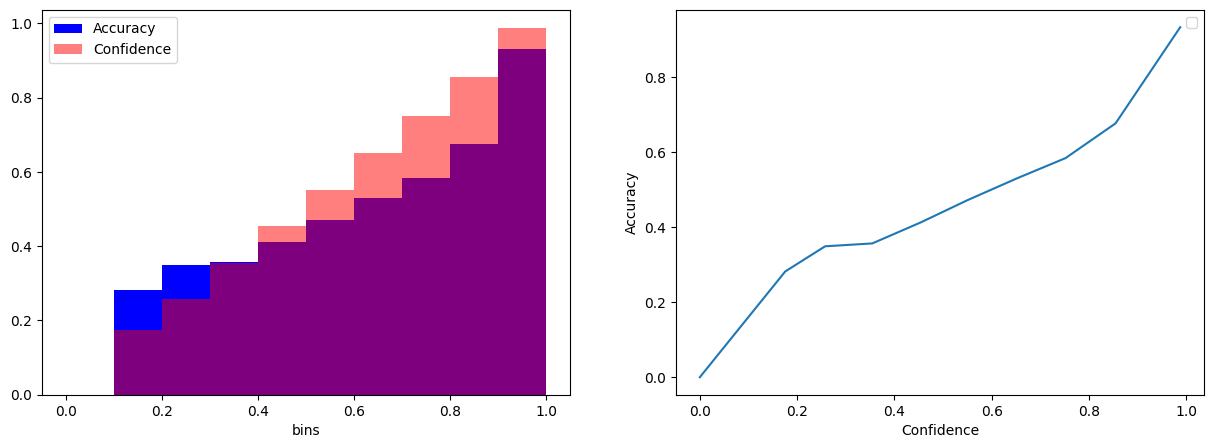

In [23]:
calc_ECE(model_resnet50)

### Extra Credit: 

**1. Transfer Learning**

=> ResNet50 - pretrained 

In [24]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

# hyperparameters
batch_size = 64  
epochs = 50
learning_rate = 0.01
n_class = 21  

model_resnet50_pretrained = fcn_resnet50(n_class=n_class, pretrained=True).to(device)
train_dl, val_dl = get_voc_dataloader(batch_size=batch_size)
optimizer = optim.SGD(model_resnet50_pretrained.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.)

train_losses_resnet50_pretrained, val_losses_resnet50_pretrained, accuracy_resnet50_pretrained = [], [], [] 
for epoch in range(epochs):
    train_loss, val_loss, accuracy = train_epoch(model_resnet50_pretrained, train_dl, val_dl, optimizer, device)
    accuracy_resnet50_pretrained.append(accuracy) 
    train_losses_resnet50_pretrained.append(train_loss) 
    val_losses_resnet50_pretrained.append(val_loss)
    print('Epoch %d: Train loss: %.3f | Val loss: %.3f | Acc: %.3f' % (epoch+1, train_loss, val_loss, accuracy)) 



/home/fashr003/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fashr003/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using downloaded and verified file: Data/VOCtrainval_06-Nov-2007.tar
Extracting Data/VOCtrainval_06-Nov-2007.tar to Data/
Using downloaded and verified file: Data/VOCtrainval_06-Nov-2007.tar
Extracting Data/VOCtrainval_06-Nov-2007.tar to Data/
Epoch 1: Train loss: 0.905 | Val loss: 0.374 | Acc: 0.880
Epoch 2: Train loss: 0.413 | Val loss: 0.436 | Acc: 0.857
Epoch 3: Train loss: 0.311 | Val loss: 0.479 | Acc: 0.842
Epoch 4: Train loss: 0.256 | Val loss: 0.468 | Acc: 0.847
Epoch 5: Train loss: 0.216 | Val loss: 0.440 | Acc: 0.854
Epoch 6: Train loss: 0.191 | Val loss: 0.412 | Acc: 0.871
Epoch 7: Train loss: 0.173 | Val loss: 0.408 | Acc: 0.873
Epoch 8: Train loss: 0.163 | Val loss: 0.412 | Acc: 0.871
Epoch 9: Train loss: 0.150 | Val loss: 0.419 | Acc: 0.870
Epoch 10: Train loss: 0.143 | Val loss: 0.419 | Acc: 0.870
Epoch 11: Train loss: 0.132 | Val loss: 0.417 | Acc: 0.872
Epoch 12: Train loss: 0.125 | Val loss: 0.417 | Acc: 0.872
Epoch 13: Train loss: 0.120 | Val loss: 0.424 | Acc: 0.87

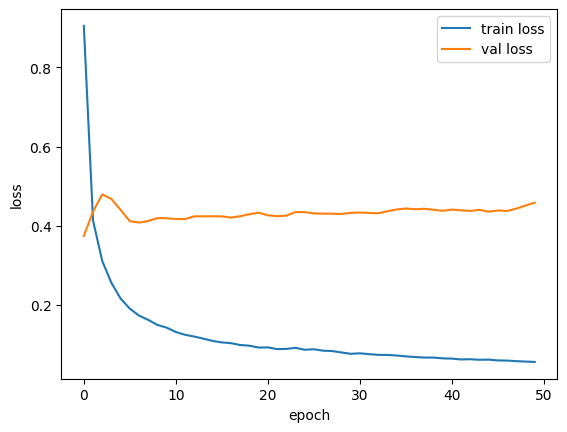

In [25]:
plot_loss(train_losses_resnet50_pretrained, val_losses_resnet50_pretrained) 

/tmp/ipykernel_2543375/1596363464.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(classes))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47


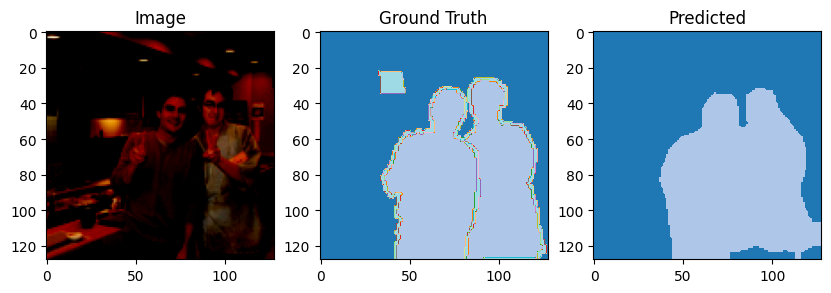

In [26]:
segmentation_plot(model_resnet50_pretrained, val_dl, 47) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ECE:  0.05437700421515576


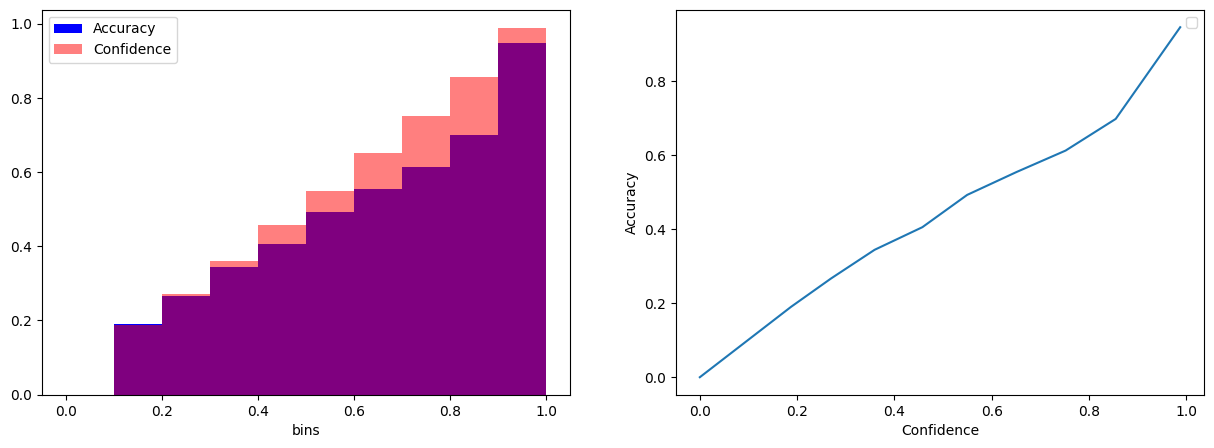

In [27]:
calc_ECE(model_resnet50_pretrained)

=> ResNet101 - not pretrained 

In [28]:
from torchvision.models.segmentation import fcn_resnet101

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

# hyperparameters
batch_size = 64  
epochs = 50
learning_rate = 0.01
n_class = 21  

model_resnet101 = fcn_resnet101(n_class=n_class).to(device)
train_dl, val_dl = get_voc_dataloader(batch_size=batch_size)
optimizer = optim.SGD(model_resnet101.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.)

train_losses_resnet101, val_losses_resnet101, accuracy_resnet101 = [], [], [] 
for epoch in range(epochs):
    train_loss, val_loss, accuracy = train_epoch(model_resnet101, train_dl, val_dl, optimizer, device)
    accuracy_resnet101.append(accuracy) 
    train_losses_resnet101.append(train_loss) 
    val_losses_resnet101.append(val_loss)
    print('Epoch %d: Train loss: %.3f | Val loss: %.3f | Acc: %.3f' % (epoch+1, train_loss, val_loss, accuracy)) 
    



Using downloaded and verified file: Data/VOCtrainval_06-Nov-2007.tar
Extracting Data/VOCtrainval_06-Nov-2007.tar to Data/
Using downloaded and verified file: Data/VOCtrainval_06-Nov-2007.tar
Extracting Data/VOCtrainval_06-Nov-2007.tar to Data/
Epoch 1: Train loss: 2.577 | Val loss: 2.454 | Acc: 0.459
Epoch 2: Train loss: 0.985 | Val loss: 1.117 | Acc: 0.738
Epoch 3: Train loss: 0.830 | Val loss: 1.279 | Acc: 0.687
Epoch 4: Train loss: 0.636 | Val loss: 0.890 | Acc: 0.767
Epoch 5: Train loss: 0.504 | Val loss: 0.821 | Acc: 0.777
Epoch 6: Train loss: 0.408 | Val loss: 1.025 | Acc: 0.752
Epoch 7: Train loss: 0.366 | Val loss: 0.945 | Acc: 0.770
Epoch 8: Train loss: 0.330 | Val loss: 0.821 | Acc: 0.789
Epoch 9: Train loss: 0.294 | Val loss: 0.799 | Acc: 0.789
Epoch 10: Train loss: 0.269 | Val loss: 0.742 | Acc: 0.795
Epoch 11: Train loss: 0.255 | Val loss: 0.703 | Acc: 0.801
Epoch 12: Train loss: 0.235 | Val loss: 0.677 | Acc: 0.806
Epoch 13: Train loss: 0.226 | Val loss: 0.663 | Acc: 0.80

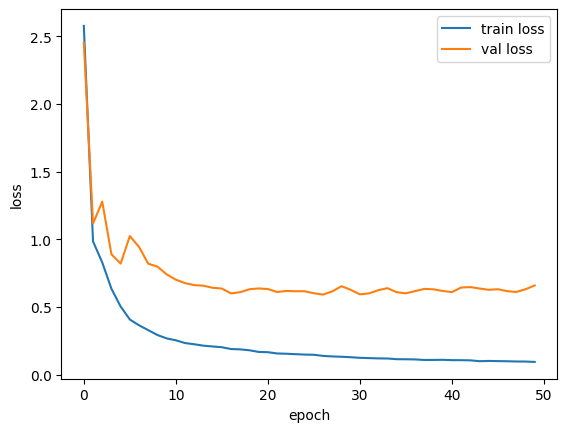

In [29]:
plot_loss(train_losses_resnet101, val_losses_resnet101) 

/tmp/ipykernel_2543375/1596363464.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(classes))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47


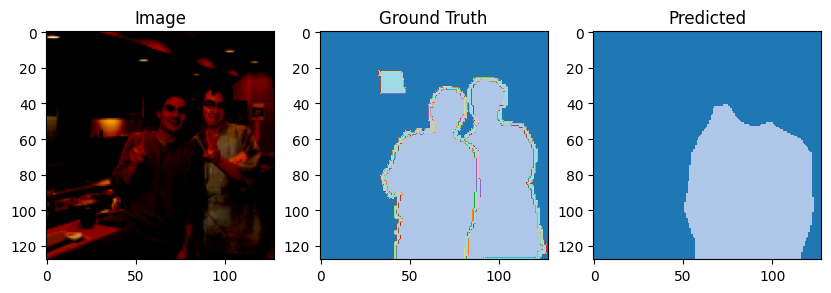

In [30]:
segmentation_plot(model_resnet101, val_dl, 47) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ECE:  0.07438639639424174


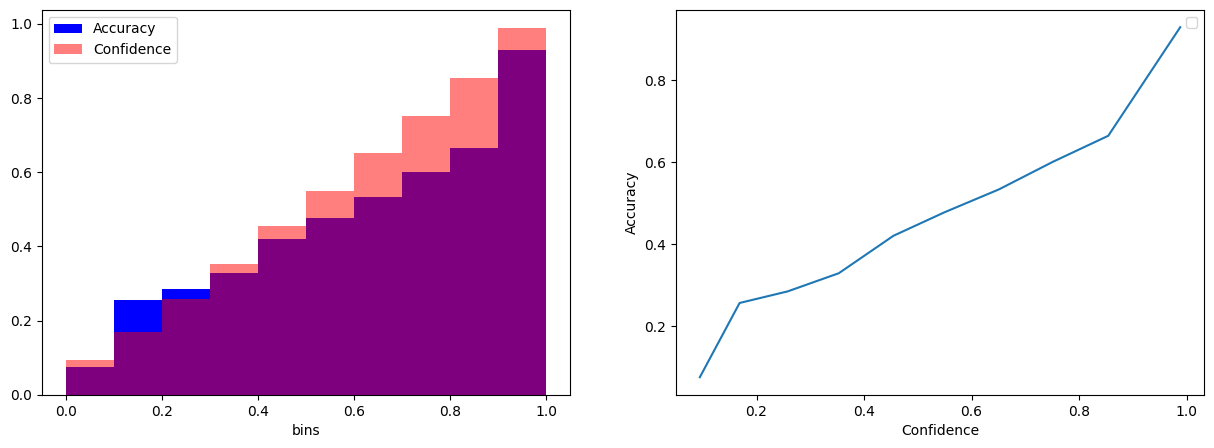

In [31]:
calc_ECE(model_resnet101)

=> ResNet101 - pretrained 

In [32]:
from torchvision.models.segmentation import fcn_resnet101

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

# hyperparameters
batch_size = 64  
epochs = 50
learning_rate = 0.01
n_class = 21   
 
model_resnet101_pretrained = fcn_resnet101(n_class=n_class, pretrained=True).to(device)
train_dl, val_dl = get_voc_dataloader(batch_size=batch_size)
optimizer = optim.SGD(model_resnet101_pretrained.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.)

train_losses_resnet101_pretrained, val_losses_resnet101_pretrained, accuracy_resnet101_pretrained = [], [], [] 
for epoch in range(epochs):
    train_loss, val_loss, accuracy = train_epoch(model_resnet101_pretrained, train_dl, val_dl, optimizer, device)
    accuracy_resnet101_pretrained.append(accuracy) 
    train_losses_resnet101_pretrained.append(train_loss) 
    val_losses_resnet101_pretrained.append(val_loss)
    print('Epoch %d: Train loss: %.3f | Val loss: %.3f | Acc: %.3f' % (epoch+1, train_loss, val_loss, accuracy)) 



/home/fashr003/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using downloaded and verified file: Data/VOCtrainval_06-Nov-2007.tar
Extracting Data/VOCtrainval_06-Nov-2007.tar to Data/
Using downloaded and verified file: Data/VOCtrainval_06-Nov-2007.tar
Extracting Data/VOCtrainval_06-Nov-2007.tar to Data/
Epoch 1: Train loss: 0.978 | Val loss: 0.387 | Acc: 0.883
Epoch 2: Train loss: 0.416 | Val loss: 0.448 | Acc: 0.863
Epoch 3: Train loss: 0.319 | Val loss: 0.834 | Acc: 0.816
Epoch 4: Train loss: 0.268 | Val loss: 0.542 | Acc: 0.854
Epoch 5: Train loss: 0.227 | Val loss: 0.510 | Acc: 0.857
Epoch 6: Train loss: 0.202 | Val loss: 0.458 | Acc: 0.859
Epoch 7: Train loss: 0.181 | Val loss: 0.449 | Acc: 0.863
Epoch 8: Train loss: 0.165 | Val loss: 0.448 | Acc: 0.863
Epoch 9: Train loss: 0.156 | Val loss: 0.446 | Acc: 0.864
Epoch 10: Train loss: 0.144 | Val loss: 0.450 | Acc: 0.863
Epoch 11: Train loss: 0.134 | Val loss: 0.452 | Acc: 0.864
Epoch 12: Train loss: 0.131 | Val loss: 0.461 | Acc: 0.863
Epoch 13: Train loss: 0.124 | Val loss: 0.472 | Acc: 0.86

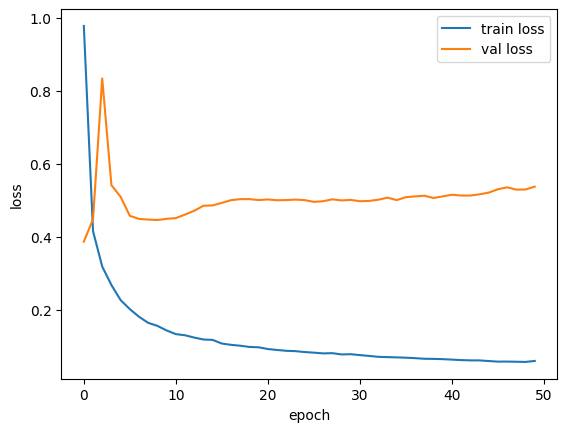

In [33]:
plot_loss(train_losses_resnet101_pretrained, val_losses_resnet101_pretrained)  

/tmp/ipykernel_2543375/1596363464.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(classes))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47


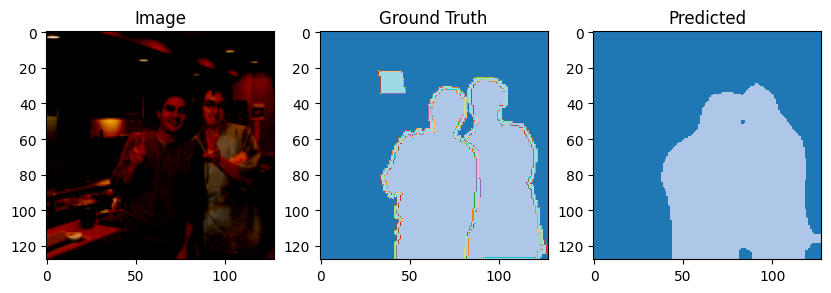

In [34]:
segmentation_plot(model_resnet101_pretrained, val_dl, 47) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ECE:  0.06405778303202743


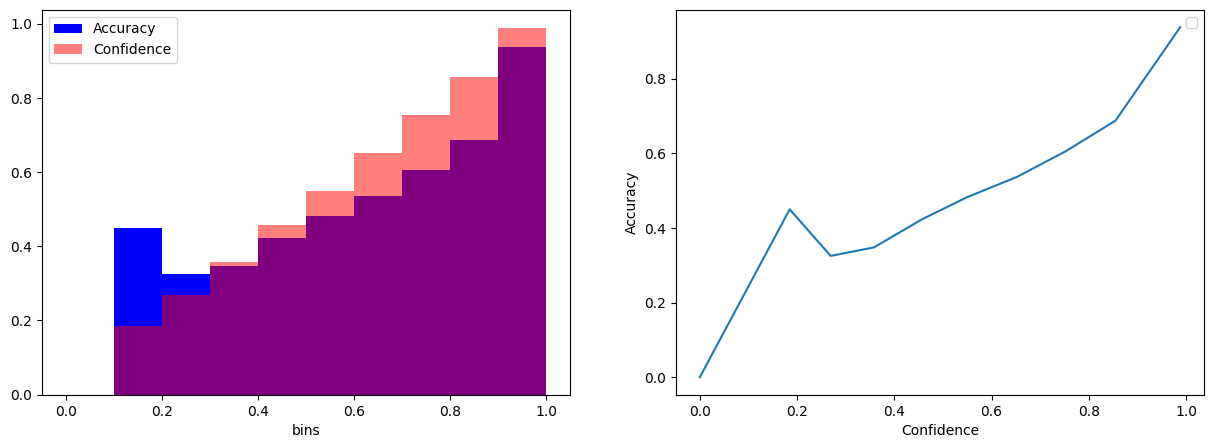

In [35]:
calc_ECE(model_resnet101_pretrained)

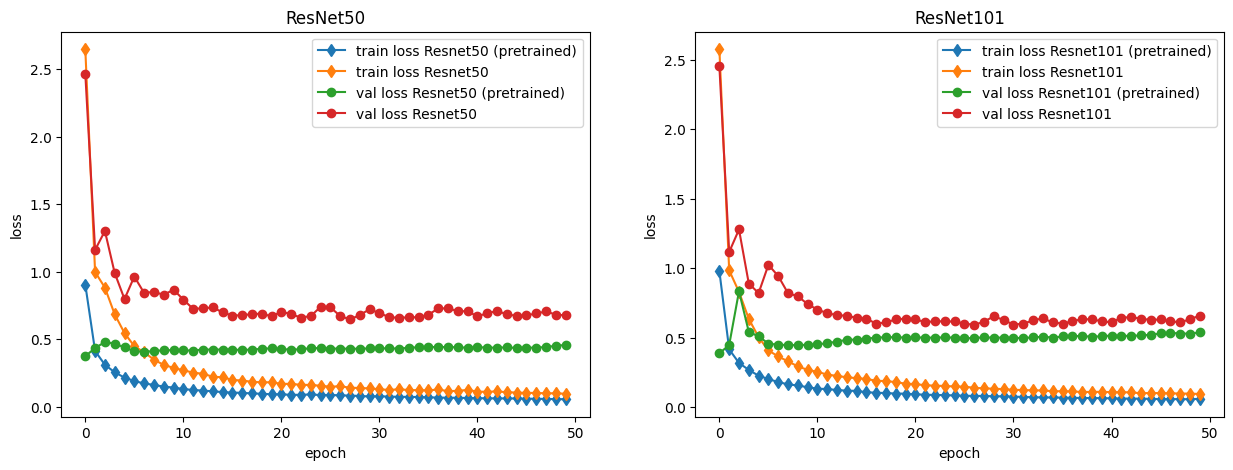

In [37]:
plt.figure(figsize=(15,5))

b = plt.subplot(121)
b.plot(train_losses_resnet50_pretrained,  marker="d", label='train loss Resnet50 (pretrained)')
b.plot(train_losses_resnet50, marker="d", label='train loss Resnet50') 
b.plot(val_losses_resnet50_pretrained, marker="o", label='val loss Resnet50 (pretrained)')
b.plot(val_losses_resnet50, marker="o", label='val loss Resnet50')
b.legend()
b.set_xlabel('epoch')
b.set_ylabel('loss') 
b.set_title('ResNet50')

a = plt.subplot(122)
a.plot(train_losses_resnet101_pretrained,  marker="d", label='train loss Resnet101 (pretrained)')
a.plot(train_losses_resnet101, marker="d", label='train loss Resnet101') 
a.plot(val_losses_resnet101_pretrained, marker="o", label='val loss Resnet101 (pretrained)')
a.plot(val_losses_resnet101, marker="o", label='val loss Resnet101')
a.legend()
a.set_xlabel('epoch')
a.set_ylabel('loss') 
a.set_title('ResNet101')

plt.show() 

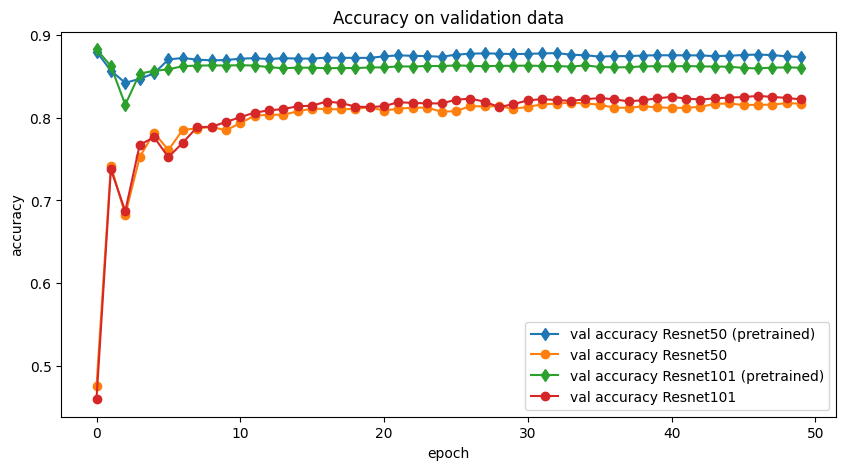

In [39]:
plt.figure(figsize=(10,5)) 
plt.plot(accuracy_resnet50_pretrained,  marker="d", label='val accuracy Resnet50 (pretrained)')
plt.plot(accuracy_resnet50, marker="o", label='val accuracy Resnet50') 
plt.plot(accuracy_resnet101_pretrained, marker="d", label='val accuracy Resnet101 (pretrained)')
plt.plot(accuracy_resnet101, marker="o", label='val accuracy Resnet101') 
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy') 
plt.title('Accuracy on validation data')
plt.show() 

#### **Hyperparameter Experiments(learning rate, weight decay)**

In [53]:
# Training loop
def train_model(model, train_dl, val_dl, num_epochs=50, learning_rate=0.01, weight_decay=0.):
     
    optimizer = optim.SGD(model_resnet50.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay) 
    train_losses, val_losses, accuracies = [], [], [] 
    for epoch in range(num_epochs):
        train_loss, val_loss, accuracy = train_epoch(model, train_dl, val_dl, optimizer, device)
        accuracies.append(accuracy) 
        train_losses.append(train_loss) 
        val_losses.append(val_loss)
        #print('Epoch %d: Train loss: %.3f | Val loss: %.3f | Acc: %.3f' % (epoch+1, train_loss, val_loss, accuracy)) 
        print(f"Epoch {epoch}", end=", ") 
    return train_losses[-1], val_losses[-1], accuracies[-1] 
    

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps') if torch.backends.mps.is_available() else device

# hyperparameters
batch_size = 64  
epochs = 50
n_class = 21  
# Load model and data
model_resnet50 = fcn_resnet50(n_class=n_class).to(device) 
train_dl, val_dl = get_voc_dataloader(batch_size=batch_size)

weight_decays = [ 0.05, 0.001]
learning_rate = [0.01, 0.05, 0.001, 0.0001]

for wd in weight_decays: 
    for lr in learning_rate: 
        tr_loss, vl_loss, acc = train_model(model_resnet50, train_dl, val_dl, learning_rate=lr, weight_decay=wd) 
        print(f"W.Decay={wd} LR={lr} => Train Loss:{tr_loss:.3f}| Val Loss: {vl_loss:.3f}| Val Acc: {acc:.3f}") 



Using downloaded and verified file: Data/VOCtrainval_06-Nov-2007.tar
Extracting Data/VOCtrainval_06-Nov-2007.tar to Data/
Using downloaded and verified file: Data/VOCtrainval_06-Nov-2007.tar
Extracting Data/VOCtrainval_06-Nov-2007.tar to Data/
Epoch 0, Epoch 1, Epoch 2, Epoch 3, Epoch 4, Epoch 5, Epoch 6, Epoch 7, Epoch 8, Epoch 9, Epoch 10, Epoch 11, Epoch 12, Epoch 13, Epoch 14, Epoch 15, Epoch 16, Epoch 17, Epoch 18, Epoch 19, Epoch 20, Epoch 21, Epoch 22, Epoch 23, Epoch 24, Epoch 25, Epoch 26, Epoch 27, Epoch 28, Epoch 29, Epoch 30, Epoch 31, Epoch 32, Epoch 33, Epoch 34, Epoch 35, Epoch 36, Epoch 37, Epoch 38, Epoch 39, Epoch 40, Epoch 41, Epoch 42, Epoch 43, Epoch 44, Epoch 45, Epoch 46, Epoch 47, Epoch 48, Epoch 49, W.Decay=0.05 LR=0.01 => Train Loss:0.215| Val Loss: 1.481| Val Acc: 0.708
Epoch 0, Epoch 1, Epoch 2, Epoch 3, Epoch 4, Epoch 5, Epoch 6, Epoch 7, Epoch 8, Epoch 9, Epoch 10, Epoch 11, Epoch 12, Epoch 13, Epoch 14, Epoch 15, Epoch 16, Epoch 17, Epoch 18, Epoch 19, Ep

In [56]:
for wd in [0.0, 0.01]:
    tr_loss, vl_loss, acc = train_model(model_resnet50, train_dl, val_dl, learning_rate=0.0001, weight_decay=wd) 
    print(f"W.Decay={wd} LR=0.0001 => Train Loss:{tr_loss:.3f}| Val Loss: {vl_loss:.3f}| Val Acc: {acc:.3f}") 

Epoch 0, Epoch 1, Epoch 2, Epoch 3, Epoch 4, Epoch 5, Epoch 6, Epoch 7, Epoch 8, Epoch 9, Epoch 10, Epoch 11, Epoch 12, Epoch 13, Epoch 14, Epoch 15, Epoch 16, Epoch 17, Epoch 18, Epoch 19, Epoch 20, Epoch 21, Epoch 22, Epoch 23, Epoch 24, Epoch 25, Epoch 26, Epoch 27, Epoch 28, Epoch 29, Epoch 30, Epoch 31, Epoch 32, Epoch 33, Epoch 34, Epoch 35, Epoch 36, Epoch 37, Epoch 38, Epoch 39, Epoch 40, Epoch 41, Epoch 42, Epoch 43, Epoch 44, Epoch 45, Epoch 46, Epoch 47, Epoch 48, Epoch 49, W.Decay=0.0 LR=0.0001 => Train Loss:0.869| Val Loss: 1.410| Val Acc: 0.695
Epoch 0, Epoch 1, Epoch 2, Epoch 3, Epoch 4, Epoch 5, Epoch 6, Epoch 7, Epoch 8, Epoch 9, Epoch 10, Epoch 11, Epoch 12, Epoch 13, Epoch 14, Epoch 15, Epoch 16, Epoch 17, Epoch 18, Epoch 19, Epoch 20, Epoch 21, Epoch 22, Epoch 23, Epoch 24, Epoch 25, Epoch 26, Epoch 27, Epoch 28, Epoch 29, Epoch 30, Epoch 31, Epoch 32, Epoch 33, Epoch 34, Epoch 35, Epoch 36, Epoch 37, Epoch 38, Epoch 39, Epoch 40, Epoch 41, Epoch 42, Epoch 43, Epoch